# Main file run this

Numpy was used to assist us with the maths,
Pandas was used for data analysis and
Matplotlib was used to create plots

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Enter Height

This cell defines the function to input the height of the person the prosthetic is for. For the purpose of this report all our data is for someone of height 180cm but any value between 95cm and 250cm is compatible

In [102]:
# define height input function
def get_height() -> float:
    while True:
        try:
            h = float(input("Enter your height in cm: ").strip())
            if 95 <= h <= 250:
                return h
            print("Enter a value between 95 and 250.")
        except ValueError:
            print("Invalid, number must be between 95 and 250")

## Compute the geometry of the leg

This function finds the Moment of Inertia `I_A` of the prosthetic based on the dimensions a prosthethic would need to be for a given height. Length of lower leg `L1`, Length of foot `L2` and distance from centre of mass to knee `L3`.
It also finds the stride `stride` of a person of the given height. 

In [103]:
def compute_geometry(height: float, mass: float):
    L1 = (height - 123) / 1.24 / 100 
    L2      = (0.044 * height + 19.286) / 100  
    stride    = (0.415 * height) / 100  

    y_bar = (L1**2) / (2 * (L1 + L2))
    L3 = L1 - y_bar
    I_A = (
        mass * (1.0 / (L1 + L2)) *
        ((1/3)*L1**3 + L1**2*L2 + (1/3)*L2**3)
    )  

    return dict(
        L3=L3, I_A=I_A, stride=stride
    )

## Define the paramaters of the gait

assuming a velocity of $3.2 kmh^{-1}$ `v_kmh` we can find the velocity in metres per second `v` which will be more useful for calculations as well as the frequency `f`, period `T` and angular frequency of the gait cycle `w`. `g` represents gravity being $9.81 ms^{-2}$ and `m` is an estimate of the mass of the prosthetic being $4kg$.

In [ ]:
# define paramters of gait
def compute_gait(stride: float):
    v_kmh = 3.2
    v = v_kmh / 3.6
    f = v / geom['stride']
    T = 1 / f
    w = 2 * np.pi * f
    return dict(
        v_kmh=v_kmh, v=v, f=f, T=T, w=w
    )

g = 9.81
mass = 4.0

## Compute Global Shank Angle
This cell finds the Global joint angles over time which it stores in list `r` with variables `shank` and `time`. THe global shank angles are found from the relative angle that it takes from `Gait_biomechanics_dataset.csv` the source of which can be found in our report

In [105]:
# converts relative joint angles to global joint angles
def compute_shank_global(df: pd.DataFrame, thigh_target_deg: float = 2.0):
    hip  = df[df.joint == 3].rename(columns={'angle': 'hip'})
    knee = df[df.joint == 2].rename(columns={'angle': 'knee'})
    keys = ['subject', 'condition', 'replication', 'leg', 'time']
    m = pd.merge(hip[keys+['hip']], knee[keys+['knee']], on=keys)

    out = []
    for _, d in m.groupby(['subject', 'replication', 'leg']):
        d = d.sort_values('time').copy()
        t = d['time'].to_numpy()
        hipj = d['hip'].to_numpy()
        mask = (t >= 0.10) & (t <= 0.30)
        tgt = np.deg2rad(thigh_target_deg)
        mean_hip = np.nanmean(hipj[mask]) if mask.any() else 0.0
        phi = tgt - mean_hip
        d['thigh'] = phi + d['hip']
        d['shank'] = d['thigh'] - d['knee']
        out.append(d)

    r = pd.concat(out, ignore_index=True)
    r['shank'] *= -1
    return r[['time', 'shank']]

## Interpolate and clean the shank angle data

This block cleans the data of the shank angles computed in the last cell. The data is then interpolated linearly and then smoothed.

In [106]:
# smooths joint angles
def build_mean_curve(shank_df: pd.DataFrame, n: int = 1001, win: int = 9):
    df = shank_df.copy()
    df['t_round'] = (df['time'] * 1000).round().astype(int) / 1000
    g = df.groupby('t_round')['shank'].mean().sort_index()

    t_src, y_src = g.index.values, g.values
    good = np.isfinite(t_src) & np.isfinite(y_src)
    t_src, y_src = t_src[good], y_src[good]

    t_norm = np.linspace(0, 1, n)
    y = np.interp(t_norm, t_src, y_src)

    # smoothing with raw window, no checks
    pad = win // 2
    ypad = np.r_[y[pad:0:-1], y, y[-2:-pad-2:-1]]
    ker = np.ones(win) / win
    y = np.convolve(ypad, ker, mode='valid')[:len(y)]

    return t_norm, y


## Find window where shank movement follows damped harmonic oscillator model

This code uses linear regression to fit the data to a damped harmonic oscillator model which as an ode $I_A\ddot{\theta} + c \dot{\theta} + k \theta =0$  and then computes $R^2$ to verify how will this fits at each point then defining a window where it very closely fits this model.

In [107]:
# find time window where shank movement follows damped harmonic oscillator model

def best_window(t, theta, wlen=0.15, search=(0.60, 0.95), step=0.005):
    best = None
    for s in np.arange(search[0], search[1]-wlen, step):
        e = s + wlen
        mask = (t >= s) & (t <= e) & np.isfinite(theta)
        if mask.sum() < 25: continue
        tt, th = t[mask], theta[mask]
        thd = np.gradient(th, tt)
        thdd = np.gradient(thd, tt)
        good = np.isfinite(th) & np.isfinite(thd) & np.isfinite(thdd)
        if good.sum() < 20: continue
        tt, th, thd, thdd = tt[good], th[good], thd[good], thdd[good]
        X = np.column_stack([thd, th])
        y = -thdd
        if np.var(y) < 1e-10: continue
        coef, *_ = np.linalg.lstsq(X, y, rcond=None)
        yfit = X @ coef
        ss_res = np.sum((y - yfit)**2)
        ss_tot = np.sum((y - y.mean())**2)
        if ss_tot <= 1e-16: continue
        R2 = 1 - ss_res/ss_tot
        if not np.isfinite(R2): continue
        if (best is None) or (R2 > best['R2']): best = dict(s=s, e=e, R2=R2)
    return best

## Solves the ODE
This cell solves the damped harmonic oscillator defined in the previous cell over the chosen window using the 4th-order Runge-Kutta which was chosen due to the marginal errors that can be acheived.

In [108]:
# define and solve ODE
def rk4_step(theta, omega, dt, I, c, k, m, g, L):
    def f1(theta, omega): return omega
    def f2(theta, omega): return -(c*omega + k*theta + m*g*L*np.sin(theta)) / I
    k1_th, k1_om = f1(theta, omega), f2(theta, omega)
    k2_th, k2_om = f1(theta+0.5*dt*k1_th, omega+0.5*dt*k1_om), f2(theta+0.5*dt*k1_th, omega+0.5*dt*k1_om)
    k3_th, k3_om = f1(theta+0.5*dt*k2_th, omega+0.5*dt*k2_om), f2(theta+0.5*dt*k2_th, omega+0.5*dt*k2_om)
    k4_th, k4_om = f1(theta+dt*k3_th, omega+dt*k3_om), f2(theta+dt*k3_th, omega+dt*k3_om)
    theta += (dt/6)*(k1_th+2*k2_th+2*k3_th+k4_th)
    omega += (dt/6)*(k1_om+2*k2_om+2*k3_om+k4_om)
    return theta, omega

def simulate_theta(t, theta0, omega0, I, c, k, m, g, L):
    theta, omega = theta0, omega0
    th = [theta]
    for i in range(1, len(t)):
        dt = t[i] - t[i-1]
        theta, omega = rk4_step(theta, omega, dt, I, c, k, m, g, L)
        th.append(theta)
    return np.array(th)

## Find the roots of the ODE solved in the previous cell
This cell first finds the error via root mean square to check the quality of the fit. Then it uses the secant method to find the roots of the ODE, secant was chosen as it is much faster than bisection and does'nt require analaytical derivatives.

In [109]:
# root finding with secant method  
def rmse(a, b): return np.sqrt(np.mean((a - b)**2))

def cost(time_s, theta_exp, theta0, omega0, I, m, g, L, k, c):
    th = simulate_theta(time_s, theta0, omega0, I, c, k, m, g, L)
    return rmse(th, theta_exp)

def dJ_dc(cf, k, c, h=1e-3, hmin=1e-6):
    h_eff = max(h, hmin)
    return (cf(k, c + h_eff) - cf(k, c - h_eff)) / (2*h_eff)

def dJ_dk(cf, k, c, h=1e-3):
    h = max(h, 1e-6)
    return (cf(k+h, c) - cf(k-h, c)) / (2*h)

def secant(g, x1, x2, tol=1e-6, maxit=30, bounds=None):
    g1, g2 = g(x1), g(x2)
    for _ in range(maxit):
        d = g2 - g1
        if abs(d) < 1e-14: break
        x3 = x2 - g2 * (x2 - x1) / d
        if bounds: lo,hi=bounds; x3 = float(np.clip(x3, lo, hi))
        g3 = g(x3)
        if abs(g3) < tol: return x3
        x1,g1,x2,g2 = x2,g2,x3,g3
    return x2

def bracket(vals, idx):
    return float(vals[max(0, idx-1)]), float(vals[min(len(vals)-1, idx+1)])

## Create Plots
This cell creates two plots.
The first plot shows where the window where the simulation follows the damped harmonic oscillator model over the full gait cycle
The second plot shows the angle over the specific window of the gait cycle comparing the fits found via each iteration of the secant method against real experimental data.

In [110]:
# plot the gait cycle with the passive window highlighted
def plot_window_highlight(t_norm, theta_mean, s, e):
    plt.figure(figsize=(9, 4.8))
    plt.plot(t_norm*100, np.degrees(theta_mean), lw=2, label='Mean shank angle (deg)')
    plt.axvspan(s*100, e*100, color='C0', alpha=0.12, label='Passive window')
    plt.xlabel("Gait cycle (%)")
    plt.ylabel("Shank angle (deg)")
    plt.title("Passive window on mean shank-angle curve")
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()

def plot_top_overlays(t_win, theta_exp, k_vals, c_vals, J_grid,
                      k_star, c_star, sim_fn, top_n=5):
    flat = np.argpartition(J_grid.ravel(), top_n)[:top_n]
    pairs = np.column_stack(np.unravel_index(flat, J_grid.shape))
    pairs = sorted(pairs, key=lambda rc: J_grid[rc[0], rc[1]])

    plt.figure(figsize=(9, 5))
    plt.plot(t_win*100, np.degrees(theta_exp), lw=2, label='Experimental (deg)')

    for rank, (ik, jc) in enumerate(pairs, 1):
        k, c = k_vals[ik], c_vals[jc]
        th = sim_fn(k, c)
        plt.plot(t_win*100, np.degrees(th),
                 '--' if rank > 1 else '-', lw=2,
                 alpha=1 if rank == 1 else 0.75,
                 label=f"#{rank}: k={k:.3f}, c={c:.3f}, J={J_grid[ik,jc]:.4f}")

    th_star = sim_fn(k_star, c_star)
    plt.plot(t_win*100, np.degrees(th_star), ':', lw=2.5,
             label=f"Refined (k*={k_star:.3f}, c*={c_star:.3f})")

    plt.xlabel('Gait Cycle (%) within window')
    plt.ylabel('Shank Angle (deg)')
    plt.title('Top grid fits + Secant-refined best (nonlinear model)')
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.show()

## Execute Complete Analysis Pipeline

This cell puts all the code defined previously together

    Initializes physical constants and computes baseline geometry

    Processes experimental gait data and identifies the passive swing phase window

    Performs grid search across parameter space to find optimal spring and damping values

    Refines parameters using iterative secant method optimization

    Generates final plots comparing model fits to experimental data

The output shows the identified passive region and optimized mechanical parameters for the prosthetic design.


Using height = 180.0 cm
Walking speed: 3.2 km/h
I_A=0.527931 kg·m²
stride=0.747 m  f=1.190 Hz  T=0.840 s
Baseline k0: 17.139 N·m/rad

Passive region: 77.5%–92.5% (R²=0.922)

Grid best:
k0=19.196064, c0=2.000000, J0=0.003419


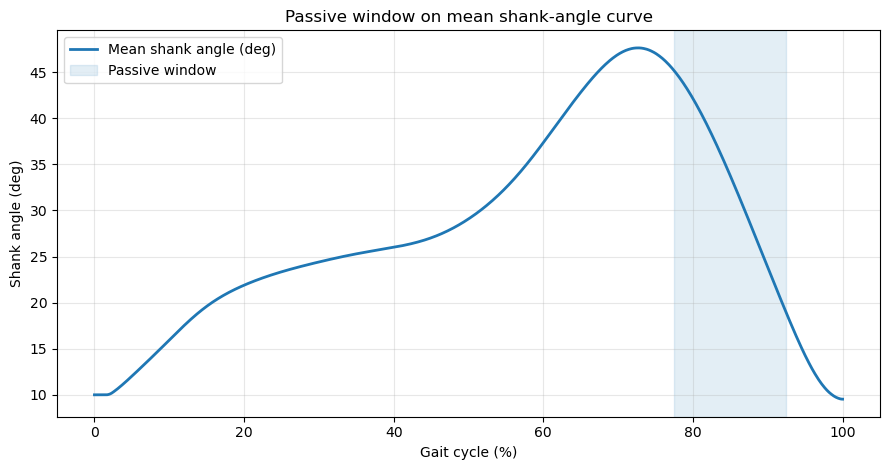

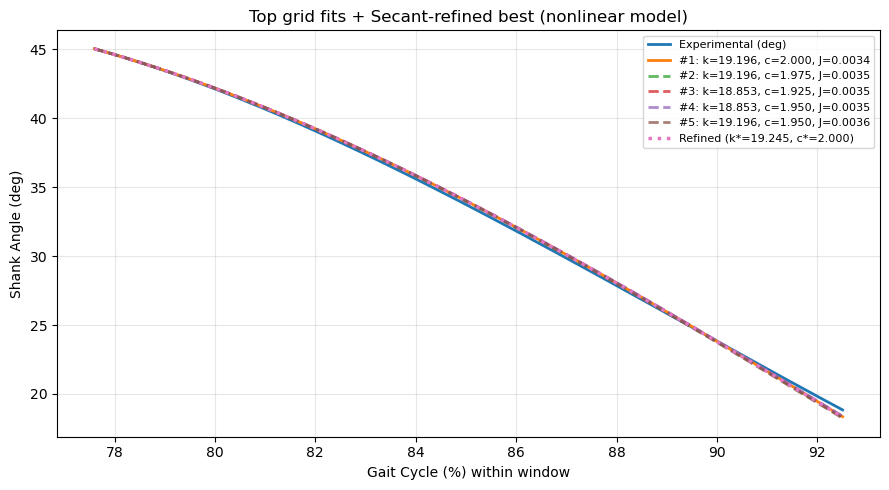

In [ ]:
# main code

height = get_height()
print(f"\nUsing height = {height:.1f} cm")

geom = compute_geometry(height, mass)
gait = compute_gait(geom['stride'])

print(f"Walking speed: {gait['v_kmh']:.1f} km/h")
print(f"I_A={geom['I_A']:.6f} kg·m²")
print(f"stride={geom['stride']:.3f} m  f={gait['f']:.3f} Hz  T={gait['T']:.3f} s")

k0 = geom['I_A'] * gait['w']**2 - mass*g*geom['L3']
print(f"Baseline k0: {k0:.3f} N·m/rad")


df = pd.read_csv("Gait_Biomechanics_Dataset.csv", encoding="latin1")
df = df[(df.condition == 1) & (df.leg == 2)].copy()

shank = compute_shank_global(df)
t, theta_mean = build_mean_curve(shank)

win = best_window(t, theta_mean, wlen=0.15)
if win is None:
    print("\nNo R² window found. Using 70–90%.")
    win = dict(s=0.70, e=0.90, R2=np.nan)

s, e = win['s'], win['e']
print(f"\nPassive region: {s*100:.1f}%–{e*100:.1f}% (R²={win['R2']:.3f})")

mask = (t >= s) & (t <= e)
t_win, theta_exp = t[mask], theta_mean[mask]
time_s = t_win * gait['T']
theta0 = float(theta_exp[0])
omega0 = float(np.gradient(theta_exp, time_s)[0])

def cf(k, c):
    return cost(time_s, theta_exp, theta0, omega0, geom['I_A'],
                mass, g, geom['L3'], k, c)

k_vals = np.linspace(max(0.05, 0.40*k0), 1.60*k0, 61)
c_vals = np.linspace(0.0, 2.0, 81)

J_grid = np.zeros((len(k_vals), len(c_vals)))
best = (np.inf, None, None)
for i, k in enumerate(k_vals):
    for j, c in enumerate(c_vals):
        J = cf(k, c)
        J_grid[i, j] = J
        if J < best[0]:
            best = (J, i, j)

J0, i0, j0 = best
k_best, c_best = float(k_vals[i0]), float(c_vals[j0])

print("\nGrid best:")
print(f"k0={k_best:.6f}, c0={c_best:.6f}, J0={J0:.6f}")

k1, k2 = bracket(k_vals, i0)
c1, c2 = bracket(c_vals, j0)

k_star, c_star = k_best, c_best
for _ in range(3):
    c_star = secant(lambda c: dJ_dc(cf, k_star, c),
                    c1, c2, tol=5e-7, bounds=(0.0, 2.0))
    c1, c2 = max(0, c_star-0.05), min(2.0, c_star+0.05)
    k_star = secant(lambda k: dJ_dk(cf, k, c_star),
                    k1, k2, tol=5e-7, bounds=(k_vals[0], k_vals[-1]))
    k1, k2 = max(k_vals[0], k_star-0.1), min(k_vals[-1], k_star+0.1)

J_star = cf(k_star, c_star)

def sim_fn(k, c):
    return simulate_theta(time_s, theta0, omega0, geom['I_A'], c, k, mass, g, geom['L3'])

plot_window_highlight(t, theta_mean, s, e)
plot_top_overlays(t_win, theta_exp, k_vals, c_vals, J_grid,
                      k_star, c_star, sim_fn, top_n=5)

